# RACE-Distractor-Generation

In [ ]:
!nvidia-smi

Sun Oct 24 08:36:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys

IN_COLAB = 'google.colab' in sys.modules
RUN_TRAINING_CELLS = IN_COLAB

EXPERIMENT_NAME = 'RACE-Distractor-Generation/'
DRIVE_FOLDER_LOCATION = '/content/drive/My Drive/QG-Colab/Github/' + EXPERIMENT_NAME

In [ ]:
# Mounting google drive
if IN_COLAB:
    from google.colab import drive

    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Environment setup
Setting up Google drive as working directory and installing packages.

In [ ]:
# Using my own Google Drive during the experiment to save all checkpoints and training logs.

if IN_COLAB:
    # Adapted from:  https://robertbrucecarter.com/writing/2020/06/setting-your-working-directory-to-google-drive-in-a-colab-notebook/
    import os 

    def create_and_set_working_directory(path: str):
        # check if your project folder exists. if not, it will be created.
        if os.path.isdir(path) == False:
            os.mkdir(path)
            print(path + ' did not exist but was created.')

        # change the OS to use your project folder as the working directory
        os.chdir(path)

        print('Working directory changed to: \n' + path)

    create_and_set_working_directory(DRIVE_FOLDER_LOCATION)
    !pwd

Working directory changed to: 
/content/drive/My Drive/QG-Colab/Github/RACE-Distractor-Generation/
/content/drive/My Drive/QG-Colab/Github/RACE-Distractor-Generation


In [ ]:
# Install packages
if IN_COLAB:
    !pip install --quiet transformers==4.3.0
    !pip install --quiet pytorch-lightning==1.2.10
    !pip install --quiet tokenizers==0.10.3

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 36.2 MB/s 
     |████████████████████████████████| 3.3 MB 36.9 MB/s 
     |████████████████████████████████| 841 kB 4.1 MB/s 
     |████████████████████████████████| 596 kB 41.8 MB/s 
     |████████████████████████████████| 176 kB 50.6 MB/s 
     |████████████████████████████████| 829 kB 43.5 MB/s 
     |████████████████████████████████| 125 kB 45.2 MB/s 
     |████████████████████████████████| 1.3 MB 30.0 MB/s 
     |████████████████████████████████| 160 kB 49.1 MB/s 
     |████████████████████████████████| 271 kB 53.0 MB/s 


In [ ]:
# Import packages
from typing import List, Dict
import tqdm.notebook as tq
from tqdm.notebook import tqdm
import json
import pandas as pd
import numpy as np

import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
    )

In [ ]:
pl.seed_everything(42)

Global seed set to 42


42

# Race Dataset 
Exploration and creation of the dataset to be used

In [ ]:
!pip --quiet install datasets

     |████████████████████████████████| 264 kB 5.2 MB/s 
     |████████████████████████████████| 243 kB 38.3 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 


In [ ]:
from datasets import load_dataset

dataset = load_dataset("race", 'all')

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset race downloaded and prepared to /root/.cache/huggingface/datasets/race/all/0.1.0/5a80ba2d003e023fdce95d01c1b02f5a70d5eb2375465bee162baf9824c91474. Subsequent calls will reuse this data.


## Exploration

In [ ]:
dataset['train']['article'][0]

'My husband is a born shopper. He loves to look at things and to touch them. He likes to compare prices between the same items in different shops. He would never think of buying anything without looking around in several different shops. On the other hand, I\'m not a shopper. I think shopping is boring and unpleasant. If I like something and I have enough money to take it, I buy it at once. I never look around for a good price or a better deal. Of course my husband and I never go shopping together. Doing shopping together would be too painful for both of us. When it comes to shopping, we go our different ways.\nSometimes I ask my son Jimmy to buy some food in the shop not far from our home. But he is always absent-minded. This was his story.\nOne day I said to him, " I hope you won\'t forget what I have told you to buy." " No," said Jimmy. "I won\'t forget. You want three oranges , six eggs and a pound of meat."\nHe went running down the street to the shop. As he ran, he said to himsel

In [ ]:
list(set(dataset['train']['answer']))

['A', 'C', 'D', 'B']

In [ ]:
dataset['train']['question'][0]

'The husband likes shopping because   _  .'

In [ ]:
dataset['train']['options'][0]

['he has much money.',
 'he likes the shops.',
 'he likes to compare the prices between the same items.',
 'he has nothing to do but shopping.']

## Create dataset for training
Extract context, correct answer, question, incorrect1, incorrect2, incorrect3

In [ ]:
def create_dataset(dataset_split):
    data_rows = []

    for i in tqdm(range(len(dataset_split))):
        curr_context = dataset_split[i]['article']
        curr_question = dataset_split[i]['question']

        all_answers = dataset_split[i]['options']
        correct_answer_index =  ord(dataset_split[i]['answer']) - 65

        curr_correct = all_answers.pop(correct_answer_index)
        curr_incorrect1 = all_answers[0]
        curr_incorrect2 = all_answers[1]
        curr_incorrect3 = all_answers[2]

        data_rows.append({
            'context': curr_context,
            'question': curr_question,
            'correct': curr_correct,
            'incorrect1': curr_incorrect1,
            'incorrect2': curr_incorrect2,
            'incorrect3': curr_incorrect3
        })

    return pd.DataFrame(data_rows)

In [ ]:
race_train_df = create_dataset(dataset['train'])

  0%|          | 0/87866 [00:00<?, ?it/s]

In [ ]:
race_dev_df = create_dataset(dataset['validation'])

  0%|          | 0/4887 [00:00<?, ?it/s]

In [ ]:
race_test_df = create_dataset(dataset['test'])

  0%|          | 0/4934 [00:00<?, ?it/s]

In [ ]:
race_train_df.head()

,context,question,correct,incorrect1,incorrect2,incorrect3
0,My husband is a born shopper. He loves to look...,The husband likes shopping because _ .,he likes to compare the prices between the sam...,he has much money.,he likes the shops.,he has nothing to do but shopping.
1,My husband is a born shopper. He loves to look...,They never go shopping together because _ .,their ways of shopping are quite different,they hate each other.,they needn't buy anything for the family,they don't have time for it.
2,My husband is a born shopper. He loves to look...,Jimmy can't do the shopping well because _ .,he is absent-minded,he is young,he often loses his money,he doesn't like shopping
3,My husband is a born shopper. He loves to look...,Jimmy didn't buy what his mother wanted becaus...,he forgot some of them,the shop was closed that day,the policeman stopped him,he gave all the money to the beggar
4,Tea drinking was common in China for nearly on...,Which of the following is true of the introduc...,Tea reached Britain from Holland.,The Britons got expensive tea from India.,The Britons were the first people in Europe wh...,It was not until the 17th century that the Bri...


In [ ]:
train_df = race_train_df
dev_df = race_dev_df
test_df = race_test_df

In [ ]:
train_df.to_csv('data/race_train_df.csv', index=False)
dev_df.to_csv('data/race_dev_df.csv', index=False)
test_df.to_csv('data/race_test_df.csv', index=False)

## Analyzing source and target token max size

Result
- Context: 484
- Answer: 27
- Question (not uset currently): 30 tokens
- Incorrect = 62

Max_len
- Source: 512 - answer (27) + sep (1) + context (484)
- Target 64 - incorrect 62 + sep (2) 

In [ ]:
model_name = 't5-small'

tokenizer = T5Tokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
context_token_lens = []
question_token_lens = []
answer_token_lens = []
incorrect_token_lens = []

for i in tq.tqdm(range(len(train_df))):
    context_token_lens.append(len(tokenizer(train_df.iloc[i]['context'])['input_ids']))
    question_token_lens.append(len(tokenizer(train_df.iloc[i]['question'])['input_ids']))
    answer_token_lens.append(len(tokenizer(train_df.iloc[i]['correct'])['input_ids']))
    incorrect_token_lens.append(len(tokenizer(train_df.iloc[i]['incorrect1'] + train_df.iloc[i]['incorrect2'] + train_df.iloc[i]['incorrect3'])['input_ids']))
    
for i in tq.tqdm(range(len(test_df))):
    context_token_lens.append(len(tokenizer(test_df.iloc[i]['context'])['input_ids']))
    question_token_lens.append(len(tokenizer(test_df.iloc[i]['question'])['input_ids']))
    answer_token_lens.append(len(tokenizer(test_df.iloc[i]['correct'])['input_ids']))
    incorrect_token_lens.append(len(tokenizer(test_df.iloc[i]['incorrect1'] + test_df.iloc[i]['incorrect2'] + test_df.iloc[i]['incorrect3'])['input_ids']))


for i in tq.tqdm(range(len(dev_df))):
    context_token_lens.append(len(tokenizer(dev_df.iloc[i]['context'])['input_ids']))
    question_token_lens.append(len(tokenizer(dev_df.iloc[i]['question'])['input_ids']))
    answer_token_lens.append(len(tokenizer(dev_df.iloc[i]['correct'])['input_ids']))
    incorrect_token_lens.append(len(tokenizer(dev_df.iloc[i]['incorrect1'] + dev_df.iloc[i]['incorrect2'] + dev_df.iloc[i]['incorrect3'])['input_ids']))

  0%|          | 0/87866 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (585 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/4934 [00:00<?, ?it/s]

  0%|          | 0/4887 [00:00<?, ?it/s]

### Context 

In [ ]:
pd.DataFrame(context_token_lens).describe()

,0
count,97687.000000
mean,366.039770
std,131.826653
min,4.000000
25%,286.000000
50%,368.000000
75%,435.000000
max,1575.000000


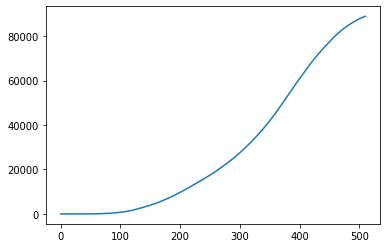

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(0, 512, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in context_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

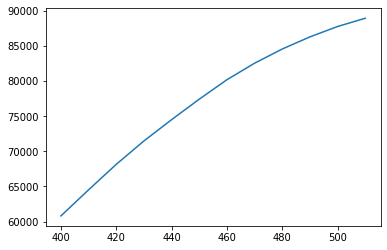

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(400, 512, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in context_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

In [ ]:
desired_max_len = 484

inside = sum(float(num) <= desired_max_len for num in context_token_lens)
outside = sum(float(num) > desired_max_len for num in context_token_lens)
percentage = 100 / len(context_token_lens) * inside

print('In  :', inside)
print('Over:', outside)
print('Percentage:', round(percentage,2))

In  : 85525
Over: 12162
Percentage: 87.55


### Question

In [ ]:
pd.DataFrame(question_token_lens).describe()

,0
count,97687.000000
mean,14.165785
std,4.456539
min,2.000000
25%,11.000000
50%,13.000000
75%,16.000000
max,90.000000


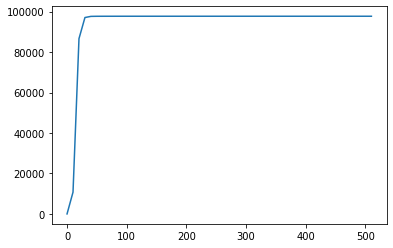

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(0, 512, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in question_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

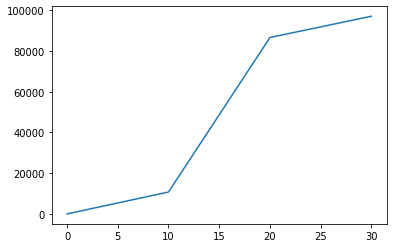

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(0, 40, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in question_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

In [ ]:
desired_max_len = 30

inside = sum(float(num) <= desired_max_len for num in question_token_lens)
outside = sum(float(num) > desired_max_len for num in question_token_lens)
percentage = 100 / len(question_token_lens) * inside

print('In  :', inside)
print('Over:', outside)
print('Percentage:', round(percentage,2))

In  : 97210
Over: 477
Percentage: 99.51


### Correct answer

In [ ]:
pd.DataFrame(answer_token_lens).describe()

,0
count,97687.000000
mean,8.447368
std,4.428004
min,2.000000
25%,5.000000
50%,8.000000
75%,11.000000
max,134.000000


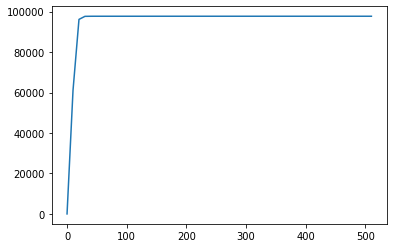

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(0, 512, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in answer_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

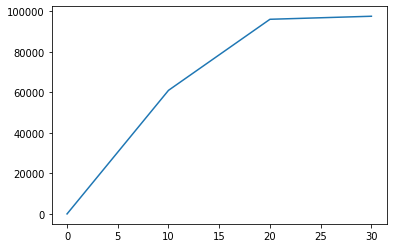

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(0, 40, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in answer_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

In [ ]:
desired_max_len = 27

inside = sum(float(num) <= desired_max_len for num in answer_token_lens)
outside = sum(float(num) > desired_max_len for num in answer_token_lens)
percentage = 100 / len(answer_token_lens) * inside

print('In  :', inside)
print('Over:', outside)
print('Percentage:', round(percentage,2))

In  : 97589
Over: 98
Percentage: 99.9


### Incorrect answers

In [ ]:
pd.DataFrame(incorrect_token_lens).describe()

,0
count,97687.000000
mean,23.394935
std,11.638691
min,3.000000
25%,14.000000
50%,23.000000
75%,31.000000
max,223.000000


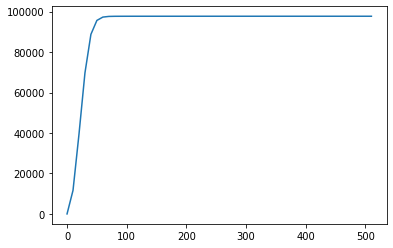

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(0, 512, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in incorrect_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

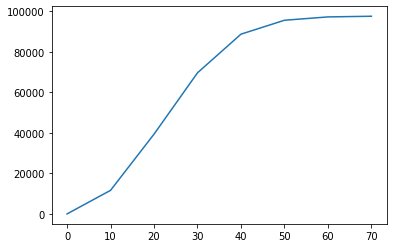

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_lens = []
samples_counts = []

for i in range(0, 80, 10):
    token_lens.append(i)
    samples_counts.append(sum(float(num) < i for num in incorrect_token_lens))

plt.plot(token_lens, samples_counts)

plt.show()

In [ ]:
desired_max_len = 62

inside = sum(float(num) <= desired_max_len for num in incorrect_token_lens)
outside = sum(float(num) > desired_max_len for num in incorrect_token_lens)
percentage = 100 / len(incorrect_token_lens) * inside

print('In  :', inside)
print('Over:', outside)
print('Percentage:', round(percentage,2))

In  : 97414
Over: 273
Percentage: 99.72


In [ ]:
(100 / (97329 + 358)) * 358 

0.36647660384698066

# Training


## Load processed RACE dataset

In [ ]:
train_df = pd.read_csv('data/race_train_df.csv')
dev_df = pd.read_csv('data/race_dev_df.csv')
test_df = pd.read_csv('data/race_test_df.csv')

In [ ]:
train_df.head()

,context,question,correct,incorrect1,incorrect2,incorrect3
0,My husband is a born shopper. He loves to look...,The husband likes shopping because _ .,he likes to compare the prices between the sam...,he has much money.,he likes the shops.,he has nothing to do but shopping.
1,My husband is a born shopper. He loves to look...,They never go shopping together because _ .,their ways of shopping are quite different,they hate each other.,they needn't buy anything for the family,they don't have time for it.
2,My husband is a born shopper. He loves to look...,Jimmy can't do the shopping well because _ .,he is absent-minded,he is young,he often loses his money,he doesn't like shopping
3,My husband is a born shopper. He loves to look...,Jimmy didn't buy what his mother wanted becaus...,he forgot some of them,the shop was closed that day,the policeman stopped him,he gave all the money to the beggar
4,Tea drinking was common in China for nearly on...,Which of the following is true of the introduc...,Tea reached Britain from Holland.,The Britons got expensive tea from India.,The Britons were the first people in Europe wh...,It was not until the 17th century that the Bri...


## PyTorch Lightning modules

In [ ]:
SEP_TOKEN = '<sep>'

In [ ]:
class QGDataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        source_max_token_len: int,
        target_max_token_len: int
        ):

        self.tokenizer = tokenizer
        self.data = data
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        source_encoding = tokenizer(
            '{} {} {} {} {}'.format(data_row['correct'], SEP_TOKEN, data_row['question'], SEP_TOKEN, data_row['context']),
            max_length= self.source_max_token_len,
            padding='max_length',
            truncation= True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
            )
    
        target_encoding = tokenizer(
            '{} {} {} {} {}'.format(data_row['incorrect1'], SEP_TOKEN, data_row['incorrect2'], SEP_TOKEN, data_row['incorrect3']),
            max_length=self.target_max_token_len,
            padding='max_length',
            truncation = True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
            )

        labels = target_encoding['input_ids']  
        labels[labels == 0] = -100

        return dict(
            answer_text = data_row['correct'],
            context = data_row['context'],
            question = data_row['question'],
            incorrect1 = data_row['incorrect1'],
            incorrect2 = data_row['incorrect2'],
            incorrect3 = data_row['incorrect3'],
            input_ids = source_encoding['input_ids'].flatten(),
            attention_mask = source_encoding['attention_mask'].flatten(),
            labels=labels.flatten()
            )

In [ ]:
class QGDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size,
        source_max_token_len: int,
        target_max_token_len: int
        ): 
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def setup(self):
        self.train_dataset = QGDataset(self.train_df, self.tokenizer, self.source_max_token_len, self.target_max_token_len)
        self.val_dataset = QGDataset(self.val_df, self.tokenizer, self.source_max_token_len, self.target_max_token_len)
        self.test_dataset = QGDataset(self.test_df, self.tokenizer, self.source_max_token_len, self.target_max_token_len)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True, num_workers = 2)

    def val_dataloader(self): 
        return DataLoader(self.val_dataset, batch_size=1, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, num_workers=2)

In [ ]:
#### Testing DataModule

# data_module = QGDataModule(train_df, dev_df, test_df, tokenizer, 2, 128, 64)
# data_module.setup()

## Hyperparameters

In [ ]:
MODEL_NAME = 't5-small'
SOURCE_MAX_TOKEN_LEN = 512
TARGET_MAX_TOKEN_LEN = 64

N_EPOCHS = 20
BATCH_SIZE = 24
LEARNING_RATE = 0.0001

MODEL_SAVE_NAME = '100200'

In [ ]:
DF_TAKE_PERCENTAGE = 1

TAKE_TRAIN = int(len(train_df) * DF_TAKE_PERCENTAGE)
TAKE_DEV = int(len(dev_df) * DF_TAKE_PERCENTAGE)
TAKE_TEST = int(len(test_df) * DF_TAKE_PERCENTAGE)

print('Taking', DF_TAKE_PERCENTAGE * 100, '%')
print(TAKE_TRAIN, 'of', len(train_df))
print(TAKE_DEV, 'of', len(dev_df))
print(TAKE_TEST, 'of', len(test_df))

Taking 100 %
87866 of 87866
4887 of 4887
4934 of 4934


### Initializing training module

#### Setting DataModule

In [ ]:
print(train_df[:TAKE_TRAIN].shape, dev_df[:TAKE_DEV].shape, test_df[:TAKE_TEST].shape)

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
print('tokenizer len before: ', len(tokenizer))
tokenizer.add_tokens(SEP_TOKEN)
print('tokenizer len after: ', len(tokenizer))
TOKENIZER_LEN = len(tokenizer)

data_module = QGDataModule(train_df[:TAKE_TRAIN], dev_df[:TAKE_DEV], test_df[:TAKE_TEST], tokenizer, BATCH_SIZE, SOURCE_MAX_TOKEN_LEN, TARGET_MAX_TOKEN_LEN)
data_module.setup()

(87866, 6) (4887, 6) (4934, 6)


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer len before:  32100
tokenizer len after:  32101


#### Setting Model

In [ ]:
class QGModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.model.resize_token_embeddings(TOKENIZER_LEN) #resizing after adding new tokens to the tokenizer

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids, attention_mask, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids, attention_mask, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids, attention_mask, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss
  
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=LEARNING_RATE)

#### Setting trainer

In [ ]:
if RUN_TRAINING_CELLS:
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints',
        filename='best-checkpoint',
        save_top_k=-1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )

In [ ]:
if RUN_TRAINING_CELLS:
    trainer = pl.Trainer(
        checkpoint_callback= checkpoint_callback,
        max_epochs=N_EPOCHS,
        gpus=1,
        progress_bar_refresh_rate=30
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


## Training

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./lightning_logs

In [ ]:
model = QGModel()
# model = QGModel.load_from_checkpoint('checkpoints/best-checkpoint-v42.ckpt')

trainer.fit(model, data_module)

**JavaScript to prevent from shutting down.**

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);

In [ ]:
trainer.test()

## Evaluate

### Load model

In [ ]:
checkpoint_path = 'checkpoints/best-checkpoint-v9.ckpt'

best_model = QGModel.load_from_checkpoint(checkpoint_path)
best_model.freeze()
best_model.eval()

print()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

### Common functions

In [ ]:
SEP_TOKEN

'<sep>'

In [ ]:
def generate(qgmodel: QGModel, answer: str, context: str) -> str:
    source_encoding = tokenizer(
        '{} {} {}'.format(answer, SEP_TOKEN, context),
        max_length=SOURCE_MAX_TOKEN_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )

    generated_ids = qgmodel.model.generate(
        input_ids=source_encoding['input_ids'],
        attention_mask=source_encoding['attention_mask'],
        num_beams=1,
        max_length=TARGET_MAX_TOKEN_LEN,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
        use_cache=True
    )

    preds = {
        tokenizer.decode(generated_id, skip_special_tokens=False, clean_up_tokenization_spaces=True)
        for generated_id in generated_ids
    }

    return ''.join(preds)

In [ ]:
def show_result(generated: str, answer: str, context:str, incorrect: List[str] = [], question: str = ''):
    print('Context:')
    print(context)
    print()

    if question: print('Question: ', question)
    print('Answer : ', answer)

    print()
    print('Original : ', incorrect)
    print('Generated: ', generated)
    print('-----------------------------')

### View results manually 

In [ ]:
sample = test_df.iloc[42]

generated = generate(best_model, sample['correct'], sample['context'])
show_result(generated, sample['correct'], sample['context'], [sample['incorrect1'], sample['incorrect2'], sample['incorrect3']], sample['question'])

Context:
Sir Steven Redgrave
Winner of 5 Olympic Gold Medals
"In 1997 I was found to have developed diabetes . Believing my career was over, I felt extremely low. Then one of the specialists said there was no reason why I should stop training and competing. That was it -- the encouragement I needed. I could still be a winner if I believed in myself. I am not saying that it isn't difficult sometimes. But I wanted to prove to myself that I wasn't finished yet. Nothing is to stand in my way."
Karen Pickering
Swimming World Champion
"I swim 4 hours a day, 6 days a week. I manage that sort of workload by putting it on top of my diary. This is the key to success -- you can't follow a career in any field without being well-organized. List what you believe you can achieve. Trust yourself, write down your goals for the day, however small they are, and you'll be a step closer to achieving them."
Kirsten Best
Poet & Writer
"When things are getting hard, a voice inside my head tells me that I can'

In [ ]:
sample = test_df.iloc[4]

generated = generate(best_model, sample['correct'], sample['context'])
show_result(generated, sample['correct'], sample['context'], [sample['incorrect1'], sample['incorrect2'], sample['incorrect3']], sample['question'])

Context:
Studies show that you may be lied to every day anywhere from 10 to 200 times. We say, "Nice song." "Honey, you don't look fat in that, no." But another study showed that strangers lied three times within the first 10 minutes of meeting each other. We lie more to strangers than we lie to coworkers. Men lie eight times more about themselves than they do other people. Women lie more to protect other people. If you're married, you're going to lie to your wife/ husband in one out of every 10 communications. If you're unmarried, that number drops to three. But look, if at some point you got lied to, it's because you agreed to get lied to. Truth about lying: lying's a cooperative act. Not all lies are harmful. Sometimes we're willing to lie for the sake of social dignity  , maybe to keep a private secret.
Lying is complex. It's woven into the fabric of our daily and business lives. We're deeply disturbed by the truth. We explain it, sometimes for very good reasons, other times just b

In [ ]:
sample = train_df.iloc[42]

generated = generate(best_model, sample['correct'], sample['context'])
show_result(generated, sample['correct'], sample['context'], [sample['incorrect1'], sample['incorrect2'], sample['incorrect3']], sample['question'])

Context:
Stay in the magic with your friends and family and book a hotel stay at either Disney's Hollywood Hotel or Hong Kong Disneyland Hotel.As a hotel guest, you can enjoy an extra day at Hong Kong Disneyland Park during your stay when you buy a one-day ticket!
How It Works
Hotel guests staying at either the Disney's Hollywood Hotel or Hong Kong Disneyland Hotel who buy a Hong Kong Disneyland Park ticket will receive an extra park admission for the following day.Guests can buy Stay and Play for 2 Days tickets as soon as you check in at the Front Desk.Ticket price will be based on the first day a guest visits the Park.If the first visit day is a Regular Day, guests can buy Regular Day tickets even though the following day may be a Peak or Special Day.If the first visit day is a Peak  Day, Guests should buy Peak Day tickets even though the following day may be a Regular Day.
This offer is available 13 May through 30 September 2006.Guests who have bought their Hong Kong Disneyland Park

In [ ]:
def generate(qgmodel: QGModel, answer: str, context: str, generate_count: int) -> str:
    source_encoding = tokenizer(
        '{} {} {}'.format(answer, SEP_TOKEN, context),
        max_length=SOURCE_MAX_TOKEN_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )

    generated_ids = qgmodel.model.generate(
        input_ids=source_encoding['input_ids'],
        attention_mask=source_encoding['attention_mask'],
        num_beams=generate_count,
        num_return_sequences=generate_count,
        max_length=TARGET_MAX_TOKEN_LEN,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
        use_cache=True
    )

    preds = {
        tokenizer.decode(generated_id, skip_special_tokens=False, clean_up_tokenization_spaces=True)
        for generated_id in generated_ids
    }

    return ''.join(preds)

In [ ]:
for i in range(10):

    sample = test_df.iloc[i]
    
    print(sample['question'])
    print(sample['correct'])
    print(sample['incorrect1'], ' | ', sample['incorrect2'], ' | ', sample['incorrect3'])
    
    for beam in generate(best_model, sample['correct'], sample['context'], 1).split('</s>'):
        print(beam)
    print()

From Para.1 we learn that lying is very   _  .
common
harmful  |  easy  |  interesting
<pad> common<sep> common<extra_id_29> difficult


According to the passage, a lie works when   _  .
someone gives the liar cooperation
the liar's words are sweet enough  |  it is given to a complete stranger  |  we are willing to lie for the dignity
<pad> someone is a good person<sep> people are not willing to lie for the sake of social dignity<extra_id_29> people don't like lying


Lying is complex because   _  .
people are for it as well as against it
it is practiced by clever ones  |  ancient stories are full of lies  |  it is the whole part of great culture
<pad> people are not for it<sep> people don't like it as much to others than against them<extra_id_29> people are not for it but against it


The examples of kids lying in the passage show   _  .
lying is a sign of intelligent development
lying is good for children's growing up  |  at what age children begin to tell lies  |  9-year-old childre

In [ ]:
for i in range(10):

    sample = test_df.iloc[i]
    
    print(sample['question'])
    print(sample['correct'])
    print(sample['incorrect1'], ' | ', sample['incorrect2'], ' | ', sample['incorrect3'])
    
    for beam in generate(best_model, sample['correct'], sample['context'], 4).split('</s>'):
        print(beam)
    print()

From Para.1 we learn that lying is very   _  .
common
harmful  |  easy  |  interesting
<pad> common<sep> dangerous<sep> difficult
<pad> common<sep> difficult<sep> dangerous
<pad> common<sep> difficult<sep> easy
<pad> difficult<sep> dangerous<sep> useful


According to the passage, a lie works when   _  .
someone gives the liar cooperation
the liar's words are sweet enough  |  it is given to a complete stranger  |  we are willing to lie for the dignity
<pad> a person is willing to lie<sep> a person can't be lied to<sep> someone doesn't know the truth
<pad><pad><pad> a person is willing to lie<sep> a person can't be lied to<sep> people don't know how to lie
<pad><pad> a person is willing to lie<sep> a person can't be lied to<sep> people don't know the truth
<pad><pad><pad> a person is willing to lie<sep> a person can't be lied to<sep> someone doesn't want to be lied


Lying is complex because   _  .
people are for it as well as against it
it is practiced by clever ones  |  ancient storie

# Evaluate NLTK BLEU

In [ ]:
checkpoint_path = 'checkpoints/best-checkpoint-v16.ckpt'

best_model = QGModel.load_from_checkpoint(checkpoint_path)
best_model.freeze()
best_model.eval()

print()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

### Common functions

In [ ]:
SEP_TOKEN

'<sep>'

In [ ]:
def generate(qgmodel: QGModel, correct: str, question: str, context: str) -> str:
    source_encoding = tokenizer(
        '{} {} {} {} {}'.format(correct, SEP_TOKEN, question, SEP_TOKEN, context),
        max_length= SOURCE_MAX_TOKEN_LEN,
        padding='max_length',
        truncation= True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
        )

    generated_ids = qgmodel.model.generate(
        input_ids=source_encoding['input_ids'],
        attention_mask=source_encoding['attention_mask'],
        num_beams=1,
        max_length=TARGET_MAX_TOKEN_LEN,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
        use_cache=True
    )

    preds = {
        tokenizer.decode(generated_id, skip_special_tokens=False, clean_up_tokenization_spaces=True)
        for generated_id in generated_ids
    }

    return ''.join(preds)

In [ ]:
def show_result(generated: str, answer: str, context:str, incorrect: List[str] = [], question: str = ''):
    print('Context:')
    print(context)
    print()

    if question: print('Question: ', question)
    print('Answer : ', answer)

    print()
    print('Original : ', incorrect)
    print('Generated: ', generated)
    print('-----------------------------')

### NLTK BLEU EVAL

In [ ]:
from typing import List
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def calculate_nltk_bleu_single(references: List[str], hypothesis: str):

    if hypothesis == '': 
        return 0, 0, 0, 0 

    # Word tokenize
    refs_tokenized = list(map(lambda x: word_tokenize(x), references))
    hyp_tokenized = word_tokenize(hypothesis)

    # Smoothing function to avoid the cases where it resuts 1.0 in the cases when // Corpus/Sentence contains 0 counts of 2-gram overlaps. BLEU scores might be undesirable; use SmoothingFunction() //
    chencherry = SmoothingFunction()

    bleu_1 = sentence_bleu(refs_tokenized, hyp_tokenized, weights=(1, 0, 0, 0), smoothing_function=chencherry.method2)
    bleu_2 = sentence_bleu(refs_tokenized, hyp_tokenized, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method2)
    bleu_3 = sentence_bleu(refs_tokenized, hyp_tokenized, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method2)
    bleu_4 = sentence_bleu(refs_tokenized, hyp_tokenized, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method2)

    return bleu_1, bleu_2, bleu_3, bleu_4

In [ ]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def calculate_nltk_bleu(references: List[List[str]], hypothesis: List[str]):

    assert len(references) == len(hypothesis)
        
    bleu_totals = [0, 0, 0, 0]

    for i in tqdm(range(len(references))):
        curr_bleu = calculate_nltk_bleu_single(references[i], hypothesis[i])

        bleu_totals[0] += curr_bleu[0]
        bleu_totals[1] += curr_bleu[1]
        bleu_totals[2] += curr_bleu[2]
        bleu_totals[3] += curr_bleu[3]

    return (round(bleu_totals[0] / len(references) * 100, 2),
            round(bleu_totals[1] / len(references) * 100, 2),
            round(bleu_totals[2] / len(references) * 100, 2),
            round(bleu_totals[3] / len(references) * 100, 2))
    

### Generate results

In [ ]:
results = []

for i in tqdm(range(len(test_df))):
    sample = test_df.iloc[i]

    results.append(generate(best_model, 1, sample['correct'], sample['question'], sample['context']))

  0%|          | 0/4934 [00:00<?, ?it/s]

In [ ]:
path = DRIVE_FOLDER_LOCATION + 'results/' + 'results-epoch4' + '.txt'

with open(path, "w") as output:
    for row in results:
        output.write(str(row) + '\n')

## Evaluate final results

### Load predictions

In [ ]:
from typing import List

def load_lines_from_txt(file_path: str) -> List[str]:
    lines = []

    with open(file_path) as f:
        lines = f.readlines()

    for i in range(len(lines)):
        lines[i] = lines[i].strip()

    return lines

In [ ]:
results = load_lines_from_txt('results/results-epoch4.txt')

### Split distractors 

In [ ]:
def fucking_correct_index_of(text:str, substring: str, start_index: int = 0):
    try:
        index = text.index(substring, start_index)
    except ValueError:
        index = -1

    return index

def replace_all_extra_id(text: str):
    new_text = text
    start_index_of_extra_id = 0

    while (fucking_correct_index_of(new_text, '<extra_id_') >= 0):
        start_index_of_extra_id = fucking_correct_index_of(new_text, '<extra_id_', start_index_of_extra_id)
        end_index_of_extra_id = fucking_correct_index_of(new_text, '>', start_index_of_extra_id)

        new_text = new_text[:start_index_of_extra_id] + '<sep>' + new_text[end_index_of_extra_id + 1:]

    return new_text

In [ ]:
incorrect1s = []
incorrect2s = []
incorrect3s = []

for result in results:    
    cleaned_result = result.replace('<pad>', '').replace('</s>', '')
    cleaned_result = replace_all_extra_id(cleaned_result)
    distractors = cleaned_result.split('<sep>')

    if len(distractors) != 3:
        if len(distractors) == 2:
            print('2 answers at', result)
            distractors.append('')
        else:
            print('1 distractor', result, 'not enough distractors??')
            distractors.append('')
            distractors.append('')
            distractors.append('')
            
    incorrect1s.append(distractors[0])
    incorrect2s.append(distractors[1])
    incorrect3s.append(distractors[2])

### Load references

In [ ]:
reference_correct = list(test_df['correct'])

In [ ]:
reference_correct[:10]

['common',
 'someone gives the liar cooperation',
 'people are for it as well as against it',
 'lying is a sign of intelligent development',
 'How to tell truth from lies.',
 'his daughter was just born',
 "thinks it's natural to have setbacks in life",
 'his will to overcome difficulty',
 'Ability comes first.',
 'live like a normal person']

In [ ]:
reference_incorrects = []

for i in range(len(test_df)):
    reference_incorrects.append([test_df.iloc[i]['incorrect1'], test_df.iloc[i]['incorrect2'], test_df.iloc[i]['incorrect3']])

In [ ]:
reference_incorrects[42]

['Specialists offered him medical advice.',
 'Training helped him defeat his disease.',
 'Difficulties influenced his career.']

### Evaluate

In [ ]:
bleu_scores = []

bleu_scores.append(calculate_nltk_bleu(reference_incorrects, incorrect1s))
bleu_scores.append(calculate_nltk_bleu(reference_incorrects, incorrect2s))
bleu_scores.append(calculate_nltk_bleu(reference_incorrects, incorrect3s))

bleu_scores.append(calculate_nltk_bleu(reference_correct, incorrect1s))
bleu_scores.append(calculate_nltk_bleu(reference_correct, incorrect2s))
bleu_scores.append(calculate_nltk_bleu(reference_correct, incorrect3s))

print('###', 'bleu_1', 'bleu_2', 'bleu_3', 'bleu_4')
labels = ['d1i', 'd2i', 'd3i', 'd1c', 'd2c', 'd3c']

for i in range(len(bleu_scores)):
    print(labels[i], "{:<7}".format(bleu_scores[i][0]), "{:<7}".format(bleu_scores[i][1]), "{:<7}".format(bleu_scores[i][2]), "{:<7}".format(bleu_scores[i][3]))


  0%|          | 0/4934 [00:00<?, ?it/s]

  0%|          | 0/4934 [00:00<?, ?it/s]

  0%|          | 0/4934 [00:00<?, ?it/s]

  0%|          | 0/4934 [00:00<?, ?it/s]

  0%|          | 0/4934 [00:00<?, ?it/s]

  0%|          | 0/4934 [00:00<?, ?it/s]

### bleu_1 bleu_2 bleu_3 bleu_4
d1i 46.37   35.46   31.22   29.11  
d2i 32.19   22.6    19.32   17.69  
d3i 34.47   25.92   22.69   21.13  
d1c 17.32   13.01   12.74   12.87  
d2c 7.28    5.29    5.08    4.99   
d3c 6.55    5.02    4.94    4.99   
